# Energy levels vs. $V_G$ and the charge density distribution

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
from scipy import optimize
import logging
import cPickle as pickle
import kwant
import dolfin
import electrostatics as estat
import generate_system
logging.getLogger('FFC').setLevel(logging.WARNING)

In [3]:
"""Set system dimensions and constants"""

hbar = 1.055e-34
m = 9.109e-31
meff = 0.014*m
akwant, aFEM = 2.5e-9, 5e-9
eV, e = 1.6023e-19, 1.6023e-19
eps0 = 8.854e-12
gamma=hbar**2/(2*meff*akwant**2)
energy_par = estat.EnergyParameters(akwant=akwant, eps_dielec=8.0, eps_wire=17.7, 
                                    gamma=hbar**2/(2*meff*akwant**2),
                                    scaler=eV/gamma, bandgap=0.1, Delta=0.5e-3, 
                                    poisson_scale=e*aFEM**2/(akwant**3*eps0),
                                    miliscaler = 1000*gamma/eV)

dimension_par = estat.DimensionParameters(radius=50e-9/aFEM, top=250e-9/aFEM, 
                                          top_sc=187e-9/aFEM - 10*np.sin(np.pi/3.0),
                                          side=300e-9/aFEM, dielec_thickness=30e-9/aFEM)
solver_kwargs = {'alpha': 0.5, 'M': 5, 'verbose': 0, 'f_tol': 1e-7, 'maxiter': 200} 

environment_parameters = [{'V_G': 0.1784, 'V_SC': 'No SC', 'l_SO': 233e-9, 
                          'tag': 'No SC'},
                         {'V_G': 0.41, 'V_SC': 0.0, 'l_SO': 233e-9, 
                          'tag': '0V, 233nm'},
                         {'V_G': -0.4, 'V_SC': 0.2, 'l_SO': 233e-9, 
                           'tag': '02V, 233nm'}]

In [4]:
def energy_spectrum(potential, Ez, l_SO, sigma, energy_par, discr_par):
    """ Computes the eigenmodes and energies at a given potential.

    Parameters:
    -----------
    potential : numpy.array
        Array with potential values on the FEM mesh
    sigma : float
        Lower bound to the Hamiltonian eigenvalues
    energy_par: EnergyParameters
        Energy parameters of the model
    discr_par : DiscretizationParameters
        Discretization parameters of the model

    Returns:
    --------
    energies : list
        List containing the lowest eigen energies of the Hamiltonian
        in units of t
    density : numpy.array
        Array with charge density values
    wave_modes : list
        List with arrays of wave functions of the lowest modes
        of the Hamiltonian
    n : float
        electron density at Fermi level
    """
    kwant_potential = estat.transform_poisson_to_kwant(potential, discr_par)
    density, energies, chem_pot, wave_modes, n = estat.charge_density(kwant_potential, 
                                                                      Ez, l_SO, sigma, 
                                                                      energy_par, 
                                                                      discr_par)[:5]
    return energies, density, wave_modes, n

## Compute the density and potential of the first band, close to the band bottom

In [5]:
energy_par.akwant = 1.25e-9
energy_par.gamma = hbar**2/(2*meff*energy_par.akwant**2) 
energy_par.poisson_scale = e*aFEM**2/(energy_par.akwant**3*eps0)
energy_par.scaler = eV/energy_par.gamma
energy_par.miliscaler = 1000/energy_par.scaler
sys_dense = generate_system.kwant_hexagonal_nanowire(energy_par, dimension_par, a=0.25)
site_pos_dense = np.array([sys_dense.site(i).pos for i in xrange(sys_dense.graph.num_nodes)])
mesh, mesh_points, length, length_wire = generate_system.mesh_hexagonal_nanowire(dimension_par)[:4]
V = dolfin.FunctionSpace(mesh, 'Lagrange', 1)
discr_par = estat.DiscretizationParameters(sys=sys_dense, site_pos=site_pos_dense, 
                                           mesh=mesh, mesh_points=mesh_points, 
                                           length=length, length_wire=length_wire, V=V)
prf = (1/1.25)**3*1e21
initial_guess = 0.06*np.ones(length)

energies_dict = {}
wavefunction_dict = {}
density_dict = {}
potential_dict = {}
raw_potential = {}
raw_density = {}

# Solve self consistently

for i, environment in enumerate(environment_parameters):
    V_G = environment['V_G']
    V_SC = environment['V_SC']
    bound_conds = estat.BoundaryParameters(V_G=environment['V_G'],
                                       V_SC=environment['V_SC'])
    l_SO = environment['l_SO']
    alpha = akwant/l_SO
    Ez = 0
    sigma = estat.energy_lowerbound(V_G, V_SC, energy_par)
    sp_sol = optimize.anderson(estat.make_sp_sys(Ez, l_SO, bound_conds, 
                                                 generate_system.potential, sigma,
                                                 energy_par, dimension_par, discr_par),
                                                 initial_guess, **solver_kwargs)
    kwant_pot = estat.lattice_potential(sp_sol, discr_par)
    energies, density, wave_modes, n = energy_spectrum(sp_sol, Ez, l_SO, sigma, 
                                                             energy_par, discr_par)
    masked_density = kwant.plotter.mask_interpolate(site_pos_dense, 
                                                    prf*np.array(density))[0]
    masked_potential = kwant.plotter.mask_interpolate(site_pos_dense, 
                                                      np.array(kwant_pot))[0]
    energies_dict[environment['tag']] = energies
    wavefunction_dict[environment['tag']] = wave_modes
    density_dict[environment['tag']] = masked_density
    potential_dict[environment['tag']] = masked_potential
    raw_potential[environment['tag']] = kwant_pot
    raw_density[environment['tag']] = prf*np.array(density)
 
# Solve non-self consistently 

Ez = 0
bound_conds = estat.BoundaryParameters(V_G=environment_parameters[1]['V_G'],
                                       V_SC=0.0)
l_SO = 233e-9
tag = '0V, 233nm, non-selfc'
alpha = akwant/l_SO
sigma = estat.energy_lowerbound(V_G, V_SC, energy_par)
kwant_pot = estat.transform_poisson_to_kwant(initial_guess, discr_par)
kwant_density, energy_values = estat.charge_density(kwant_pot, Ez, l_SO, sigma, 
                                                    energy_par, discr_par)[:2]
poisson_density = estat.transform_kwant_to_poisson(kwant_density, energy_par, 
                                                   discr_par)
poisson_density_func = estat.reorder_source_coordinates(poisson_density, 
                                                        discr_par)
poisson_pot_new = generate_system.potential(poisson_density_func, bound_conds, 
                                            energy_par, dimension_par, discr_par)
kwant_pot_new = estat.lattice_potential(poisson_pot_new, discr_par)
energies, density, wave_modes, n = energy_spectrum(poisson_pot_new, Ez, l_SO, 
                                                         sigma, energy_par, discr_par)
masked_density = kwant.plotter.mask_interpolate(site_pos_dense, 
                                                prf*np.array(density))[0]
masked_potential = kwant.plotter.mask_interpolate(site_pos_dense, 
                                                  np.array(kwant_pot_new))[0]
energies_dict[tag] = energies
wavefunction_dict[tag] = wave_modes
density_dict[tag] = masked_density
potential_dict[tag] = masked_potential
raw_potential[tag] = kwant_pot_new
raw_density[tag] = prf*np.array(density)

## Response of the energy levels to variations in $V_G$

In [21]:
akwant = 2.5e-9
energy_par.akwant = akwant
energy_par.gamma = hbar**2/(2*meff*akwant**2) 
energy_par.scaler = eV/energy_par.gamma
energy_par.miliscaler = 1000/energy_par.scaler
energy_par.poisson_scale = e*aFEM**2/(akwant**3*eps0)
sys = generate_system.kwant_hexagonal_nanowire(energy_par, dimension_par, a=0.5)
site_pos = np.array([sys.site(i).pos for i in xrange(sys.graph.num_nodes)])
mesh, mesh_points, length, length_wire = generate_system.mesh_hexagonal_nanowire(dimension_par)[:4]
V = dolfin.FunctionSpace(mesh, 'Lagrange', 1)
discr_par = estat.DiscretizationParameters(sys=sys, site_pos=site_pos, mesh=mesh,
                                           mesh_points=mesh_points, length=length, 
                                           length_wire=length_wire, V=V)
V_G_range = np.linspace(-1, 1, 30)
energy_dict = {}

for environment in environment_parameters:
    l_SO = environment['l_SO']
    alpha = energy_par.akwant/l_SO
    V_SC = environment['V_SC']
    Ez = 0
    initial_guess = 0.06*np.ones(discr_par.length)
    energy_list = []
    
    for V_G in V_G_range:
        sigma = estat.energy_lowerbound(V_G, V_SC, energy_par)
        bound_conds = estat.BoundaryParameters(V_G=V_G, V_SC=V_SC)
        sp_sol = optimize.anderson(estat.make_sp_sys(Ez, l_SO, bound_conds,
                                                     generate_system.potential, sigma,
                                                energy_par, dimension_par, discr_par),
                                   initial_guess, **solver_kwargs)
        initial_guess = sp_sol
        energies, wave_modes = energy_spectrum(sp_sol, Ez, l_SO, sigma, 
                                                     energy_par, discr_par)[:2]
        energy_list.append(energies[0:9])
    energy_mat = energy_par.miliscaler*np.array(energy_list)
    energy_dict[environment['tag']] = energy_mat   
    
Ez = 0
V_SC = 0.0
l_SO = 233e-9
tag = '0V, 233nm, non-selfc'
initial_guess = 0.06*np.ones(length)
alpha = energy_par.akwant/l_SO
energy_list = []
for V_G in V_G_range:
    sigma = estat.energy_lowerbound(V_G, V_SC, energy_par)
    bound_conds = estat.BoundaryParameters(V_G=V_G, V_SC=V_SC)
    kwant_pot = estat.transform_poisson_to_kwant(initial_guess, discr_par)
    kwant_density, energy_values = estat.charge_density(kwant_pot, Ez, l_SO, sigma, 
                                                        energy_par, discr_par)[:2]
    poisson_density = estat.transform_kwant_to_poisson(kwant_density, 
                                                       energy_par, discr_par)
    poisson_density_func = estat.reorder_source_coordinates(poisson_density, 
                                                            discr_par)
    poisson_pot_new = generate_system.potential(poisson_density_func, bound_conds, 
                                                energy_par, dimension_par, discr_par)
    kwant_pot_new = estat.lattice_potential(poisson_pot_new, discr_par)
    energies = energy_spectrum(poisson_pot_new, Ez, l_SO, sigma, energy_par, 
                                     discr_par)[0]
    energy_list.append(energies[0:9])
energy_mat = energy_par.miliscaler*np.array(energy_list)
energy_dict[tag] = energy_mat

V_G_range_zoom = np.linspace(0.1, 0.5, 30)
V_SC = environment_parameters[0]['V_SC']
l_SO = environment_parameters[0]['l_SO']
alpha = energy_par.akwant/l_SO
tag = 'No SC zoom'
initial_guess = 0.06*np.ones(discr_par.length)
energy_list = []

for V_G in V_G_range_zoom:
        bound_conds = estat.BoundaryParameters(V_G=V_G, V_SC=V_SC)
        sigma = estat.energy_lowerbound(V_G, V_SC, energy_par)
        sp_sol = optimize.anderson(estat.make_sp_sys(Ez, l_SO, bound_conds, 
                                                     generate_system.potential, sigma,
                                                energy_par, dimension_par, discr_par),
                                   initial_guess, **solver_kwargs)
        initial_guess = sp_sol
        energies, wave_modes = energy_spectrum(sp_sol, Ez, l_SO, sigma, energy_par,
                                                     discr_par)[:2]
        energy_list.append(energies[0:9])
energy_mat = energy_par.miliscaler*np.array(energy_list)
energy_dict[tag] = energy_mat

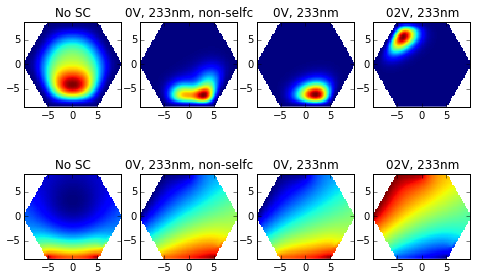

In [6]:
tag_str = ['No SC', '0V, 233nm, non-selfc', '0V, 233nm', '02V, 233nm']
fig = plt.figure(figsize=(8, 5))
for i, tag in enumerate(tag_str):
    ax = fig.add_subplot(2, 4, i+1)
    kwant.plotter.map(sys_dense, raw_density[tag], ax=ax)
    ax.set_title(tag)
for i, tag in enumerate(tag_str):
    ax = fig.add_subplot(2, 4, i+5)
    kwant.plotter.map(sys_dense, raw_potential[tag], ax=ax)
    ax.set_title(tag)
plt.show()

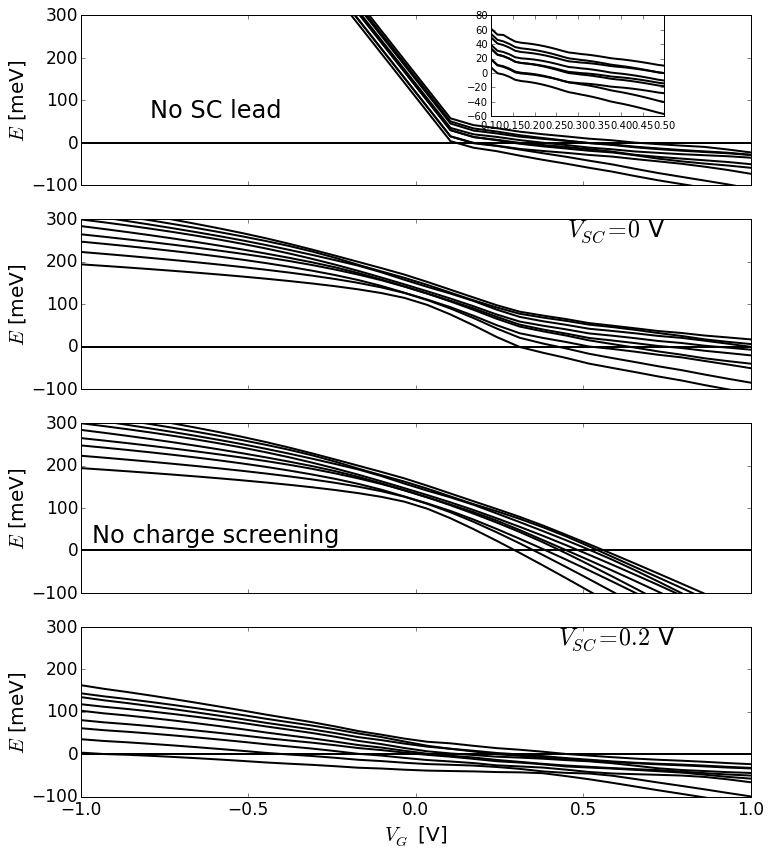

In [24]:
kw_str = ['No SC', '0V, 233nm', '02V, 233nm']
title_str = ['No SC lead', '$V_{SC} = 0$ V', '$V_{SC} = 0.2$ V']
fig = plt.figure(figsize=(12,14))

ax1 = fig.add_subplot(411)
energy_matrix = energy_dict['No SC']
V_G_cut = environment_parameters[0]['V_G']
plt.hold(True)
for j in range(len(energy_matrix[0, :])):
    ax1.plot(V_G_range, energy_matrix[:, j], 'k', lw=2)
ax1.plot(V_G_range, np.zeros(len(energy_matrix[:,0])), 'k', lw=2)
plb.setp(ax1.get_xticklabels(), visible=False)
ax1.locator_params(axis = 'y', nbins=5)
ax1.tick_params(labelsize=17)
ax1.set_ylim(-100, 300)
ax1.set_ylabel('$E$ [meV]', fontsize=20)
ax1.text(0.2, 0.4, 'No SC lead', horizontalalignment='center',\
         transform=ax1.transAxes, fontsize=24)

ax_inset = fig.add_axes([0.6, 0.8, 0.2, 0.1])
energy_matrix = energy_dict['No SC zoom']
for j in range(len(energy_matrix[0, :])):
    ax_inset.plot(V_G_range_zoom, energy_matrix[:, j], 'k', lw=2)

ax2 = fig.add_subplot(412, sharex=ax1)
energy_matrix = energy_dict['0V, 233nm']
V_G_cut = environment_parameters[1]['V_G']
plt.hold(True)
for j in range(len(energy_matrix[0, :])):
    ax2.plot(V_G_range, energy_matrix[:, j], 'k', lw=2)
ax2.plot(V_G_range, np.zeros(len(energy_matrix[:,0])), 'k', lw=2)
plb.setp(ax2.get_xticklabels(), visible=False)
ax2.locator_params(axis = 'y', nbins=5)
ax2.tick_params(labelsize=17)
ax2.set_ylim(-100, 300)
ax2.set_ylabel('$E$ [meV]', fontsize=20)
ax2.text(0.8, 0.9, '$V_{SC} = 0$ V', horizontalalignment='center',\
         transform=ax2.transAxes, fontsize=24)

ax3 = fig.add_subplot(413, sharex=ax1)
energy_matrix = energy_dict['0V, 233nm, non-selfc']
V_G_cut = environment_parameters[1]['V_G']
plt.hold(True)
for j in range(len(energy_matrix[0, :])):
    ax3.plot(V_G_range, energy_matrix[:, j], 'k', lw=2)
ax3.plot(V_G_range, np.zeros(len(energy_matrix[:,0])), 'k', lw=2)
plb.setp(ax3.get_xticklabels(), visible=False)
ax3.locator_params(axis = 'y', nbins=5)
ax3.tick_params(labelsize=17)
ax3.set_ylim(-100, 300)
ax3.set_ylabel('$E$ [meV]', fontsize=20)
ax3.text(0.2, 0.3, 'No charge screening', horizontalalignment='center',\
         transform=ax3.transAxes, fontsize=24)

ax4 = fig.add_subplot(414, sharex=ax1)
energy_matrix = energy_dict['02V, 233nm']
V_G_cut = environment_parameters[2]['V_G']
plt.hold(True)
for j in range(len(energy_matrix[0, :])):
    ax4.plot(V_G_range, energy_matrix[:, j], 'k', lw=2)
ax4.plot(V_G_range, np.zeros(len(energy_matrix[:,0])), 'k', lw=2)
plb.setp(ax4.get_xticklabels(), fontsize=17)
ax4.locator_params(axis = 'y', nbins=5)
ax4.tick_params(labelsize=17)
ax4.set_xlabel('$V_G$ [V]', fontsize=20)
ax4.set_ylabel('$E$ [meV]', fontsize=20)
ax4.set_ylim(-100, 300)
ax4.text(0.8, 0.9, '$V_{SC} = 0.2$ V', horizontalalignment='center',\
         transform=ax4.transAxes, fontsize=24)

In [25]:
"""Compute the total charge for the density distribution plots in units of e/cm"""
a_dense = 1.25e-9
prf2 = 1/(100*a_dense*prf)
print 'Charge for no SC lead attached is:', prf2*sum(raw_density['No SC']), 'e/cm'
print 'Charge for V_SC = 0 V lead is:', prf2*sum(raw_density['0V, 233nm']), 'e/cm'
print 'Charge for V_SC = 0.2 V lead is:', prf2*sum(raw_density['02V, 233nm']), 'e/cm'
print 'Charge for V_SC = 0 V lead and no charge screening is:', prf2*sum(raw_density['0V, 233nm, non-selfc']), 'e/cm'

Charge for no SC lead attached is: 579786.846245 e/cm
Charge for V_SC = 0 V lead is: 544595.294916 e/cm
Charge for V_SC = 0.2 V lead is: 534998.766524 e/cm
Charge for V_SC = 0 V lead and no charge screening is: 1616693.81811 e/cm


In [44]:
with open("data_dos_fields.p", 'wb') as fp:
    pickle.dump(density_dict, fp)
    pickle.dump(raw_density, fp)
    pickle.dump(raw_potential, fp)
    pickle.dump(site_pos_dense, fp)
    
with open("data_energy_levels.p", 'wb') as fp:
    pickle.dump(energy_dict, fp)
    pickle.dump(environment_parameters, fp)
    pickle.dump(V_G_range, fp)
    pickle.dump(V_G_range_zoom, fp)